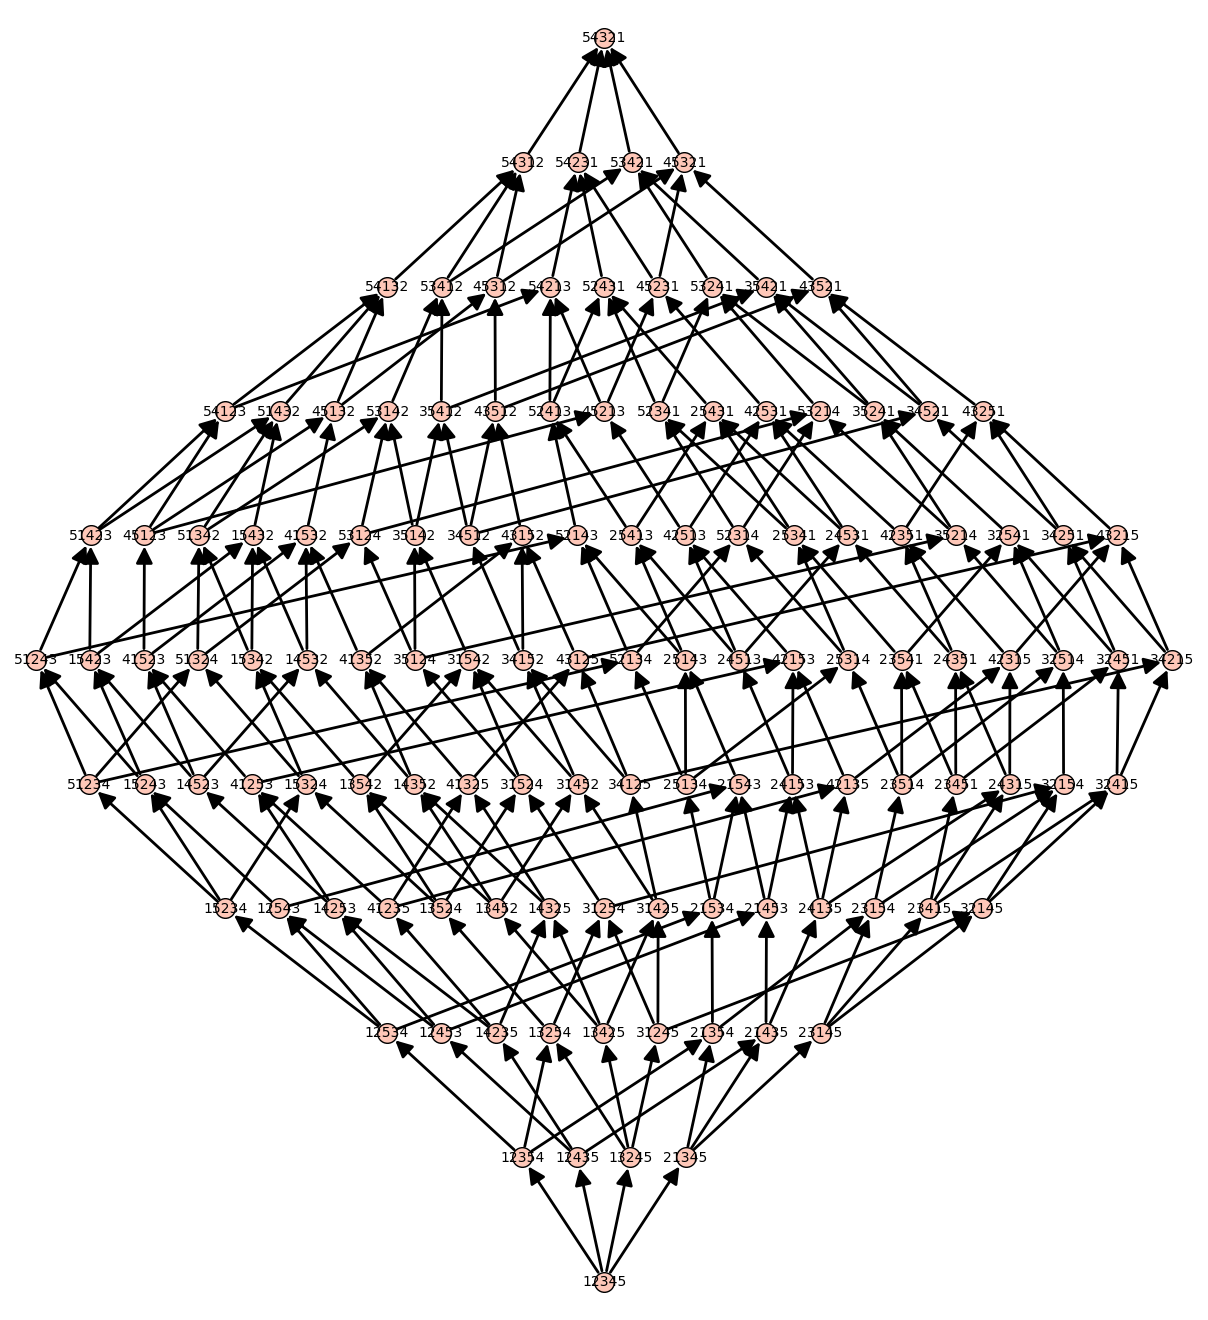

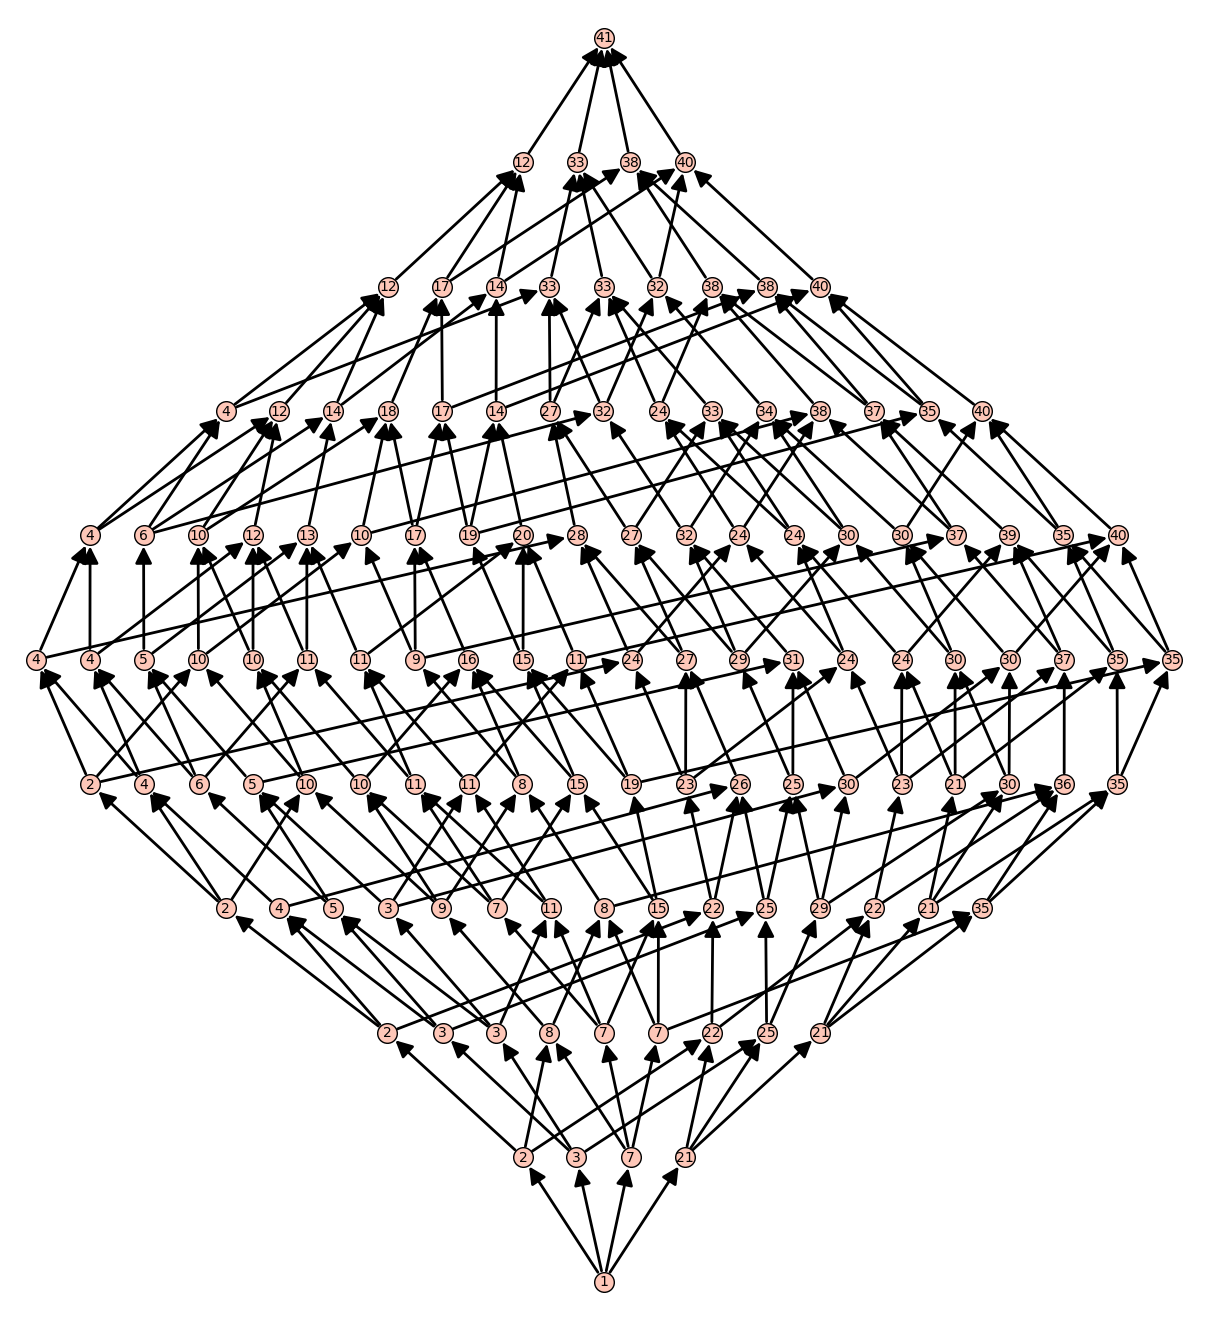

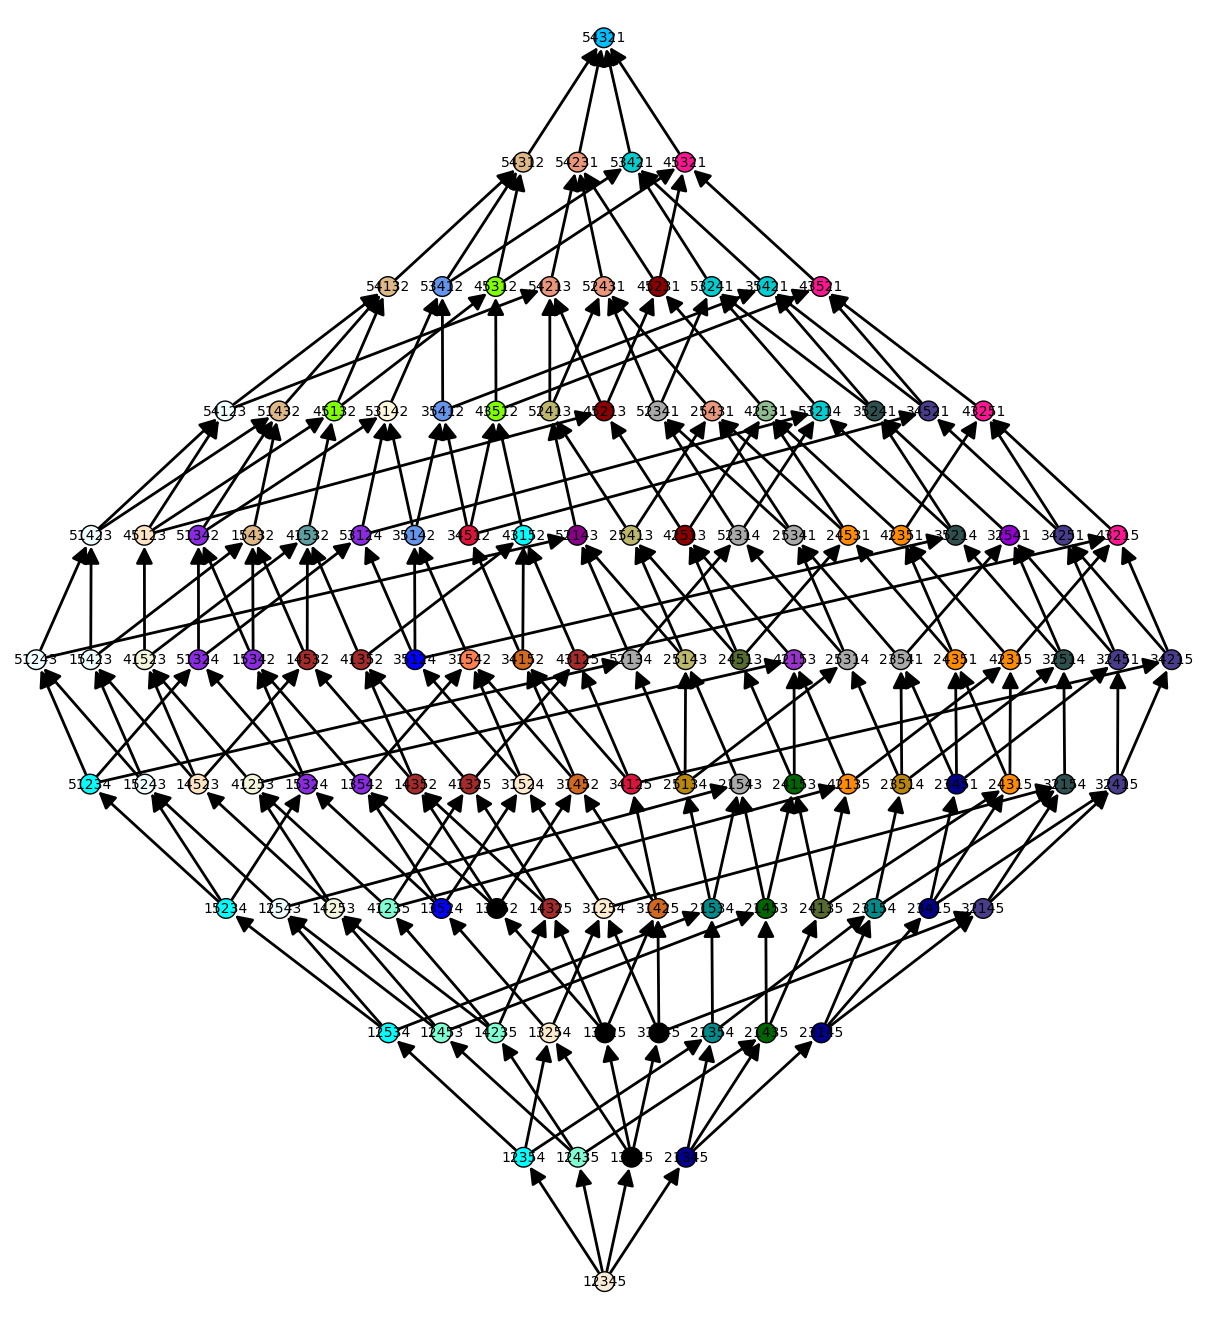

In [33]:
import matplotlib._color_data as mcd

n = 5
P = posets.SymmetricGroupWeakOrderPoset(n)

# I've been using the show() method, since it doesn't use pdflatex, which I couldn't get to work with sage
# use figsize argument to change size, default=8
P.show(figsize=20)

# use element_labels argument to relabel the elements, for instance with SD equivalence classes

sd_classes = {}
for permy in P:
    pi = []
    for ch in permy: pi.append(int(ch))
    sd_classes[permy] = SolitonDecomp(pi)

# the following command would label each permutation with its soliton decomposition
# but it's pretty unhelpful because it's really hard to read anything
#P.show(element_labels=sd_classes, figsize=40)

# there's ways around this, though, for instance we can just sub in every equivalence class with a number
sd_classes_nums = {}
tab_to_nums = {}
count = 1
for pair in sd_classes.items():
    if pair[1] in tab_to_nums.keys(): sd_classes_nums[pair[0]] = tab_to_nums[pair[1]]
    else:
        tab_to_nums[pair[1]] = count
        sd_classes_nums[pair[0]] = count
        count = count + 1
P.show(element_labels=sd_classes_nums, figsize=20)

# this is still hard to visualize, maybe colors are better?
# the argument vertex_colors has colors as keys and poset elments as values, the opposite of element_labels!
sd_classes_colors = {}
for pair in sd_classes_nums.items():
    key = list(mcd.CSS4_COLORS.keys())[pair[1]]
    if mcd.CSS4_COLORS[key] not in sd_classes_colors.keys():
        sd_classes_colors[mcd.CSS4_COLORS[key]] = []
    sd_classes_colors[mcd.CSS4_COLORS[key]].append(pair[0])
# also, please forgive the color choice lol, this was the laziest way I could think of to do this
P.show(vertex_colors=sd_classes_colors, figsize=20)

In [4]:
import sage.combinat.permutation as permutation

def BBS_move(old_state):
    # takes a list containing the integers 1-n (as well as an
    # unspecified # of zeroes) and preforms a "Fukuda" BBS move on it

    state = []
    for elt in old_state:
        state.append(elt)
        
    # naive method of preforming a move, runs in cubic? time
    # still fast enough for relatively small permuations 
    n = max(state)
    for i in range(1,n+1):
        # checks the location of each integer 1-n
        j = state.index(i)
        # if there is a zero to the right of i, preform a swap
        if 0 in state[j+1:]:
            k = state[j+1:].index(0)
            state[j], state[k+j+1] = state[k+j+1], state[j]
        # otherwise, stick i on the end of the list and put a zero where i was
        else:
            state.append(i)
            state[j] = 0
    
    return state

def BBS(arrangement, t):
    if t >= 0:
        system = [arrangement]
        for move in range(t):
            step = BBS_move(system[move])
            system.append(step)
        # THIS IS DIFFERENT FROM WHAT BBS FUNCTION RETURNS IN bbs_system.py
        # RETURNS ALL CONFIGS FOR times 0,1,...,t
        return system
    
    system = [arrangement]
    for move in range(-t):
        step = backward_move(system[move])
        system.append(step)    
    return system

def SolitonDecomp(config):
    # takes an arrangement of balls (as a list) and returns its SolitonDecomp as a Tableau
    # CONTINGENT on BBS always being sorted after n moves
    # it shouldn't be too hard to insert logic that checks to make sure we've reached when we reach a steady state
    # just feels like too much work right now
    # besides, it seems quite likely that in fact bbs IS always sorted after n moves
    
    # find the BBS configuration at t = n
    n = max(config)
    final = BBS(config, n)[n - 1]
    
    # create a list of lists sc that will store the soliton content
    sc = [[]]
    # sol_num tracks which soliton we're on (from left to right)
    sol_num = 0
    l = len(final)
    for i in range(l):
        if final[i] != 0:
            # put the current value on the end of the current soliton
            sc[sol_num].append(final[i])
            if i < l - 1:
                if final[i] >= final[i + 1]:
                    # if the next entry is smaller than current one, make a new soliton
                    sol_num = sol_num + 1
                    sc.append([])
    # sc has the solitons in the reverse order, so we have to reverse it
    return Tableau(sc[::-1])

def ss_times(n):
    # takes an integer n and returns a dictionary with keys for each 
    # permutation in Sn and values equal to number of BBS moves it takes to reach a steady state
    
    stopping_times = {}
    for sigma in SymmetricGroup(n):
        p = Permutation(sigma)
        perm = list(p)
        sd = SolitonDecomp(perm)

        # grabs the reading word of SolitonDecomp
        sd_list = []
        for l in sd[::-1]:
            for num in l:
                sd_list.append(num)

        # configs is a list containing the configuration of our permutation after t BBS moves at index t
        configs = BBS(perm, n)

        # check each time t=0,1,...,n to see if the configuration is in the steady state order
        # the first such time is the stopping time, so we store it in the dictionary and move onto the next perm
        for t in range(n + 1):
            cur = []
            for elt in configs[t]:
                if elt != 0:
                    cur.append(elt)
            if sd_list == cur:
                stopping_times[p] = t
                break
        
    return stopping_times

def backward_ss(pi):
    # make n backward moves, see what time we reach a steady state
    
    perm = list(pi)
    n = max(perm)
    # a list where the ith index is the config at t = -i
    sys = BBS(perm, -n)
    
    steady = []
    for elt in sys[n]:
        if elt != 0:
            steady.append(elt)
    
    for t in range(n + 1):
        cur = []
        for elt in sys[t]:
            if elt != 0:
                cur.append(elt)
            if cur == steady:
                return -t

def backward_move(old_state):
    # reverse and complement
    n = max(old_state)
    state = []
    for elt in old_state[::-1]:
        if elt == 0:
            state.append(elt)
        else:
            state.append(n + 1 - elt)
    
    # preform a BBS move on the reversed complement and then return
    # the reversed complement of that
    mid_state = BBS_move(state)
    new_state = []
    for elt in mid_state[::-1]:
        if elt == 0:
            new_state.append(elt)
        else:
            new_state.append(n + 1 - elt)
    
    return new_state
